# WaveRNN - Fit a Short Sample

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, sys, math
import numpy as np
import torch
from torch.autograd import Variable 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import librosa
from scipy.io import wavfile

In [2]:
notebook_name = 'nb2'
sample_rate = 22050

In [5]:
sample = wavfile.read('data/female_vocal_op8_8.wav')[1]

### Split/Combine Functions

In [6]:
def split_signal(x) :
    unsigned = x + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [7]:
def combine_signal(coarse, fine) :
    signal = coarse * 256 + fine 
    signal -= 2**15
    return signal.astype(np.int16)

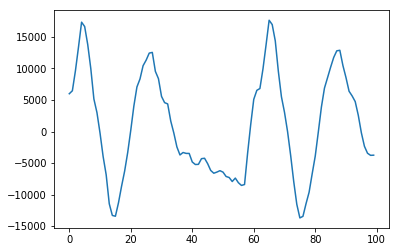

In [8]:
plt.plot(sample[3000:3100])

In [9]:
coarse_classes, fine_classes = split_signal(sample)

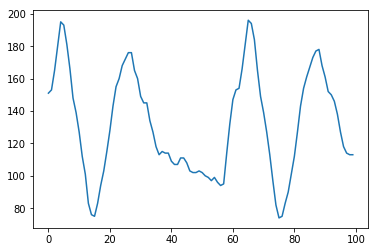

In [11]:
plt.plot(coarse_classes[3000:3100])

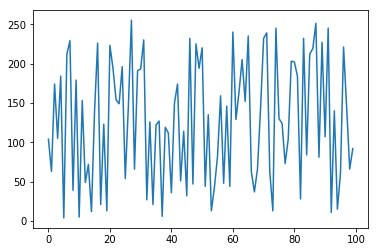

In [12]:
plt.plot(fine_classes[3000:3100])

## Model Class

In [17]:
class WaveRNN(nn.Module) :
    def __init__(self, hidden_size=896, quantisation=256) :
        ''' 
            Please refer to Equation No.2 from Deepmind's
            "Efficient Neural Audio Synthesis" paper
            for more details on variable names and ops.
            
            I'm going to stick with F.sigmoid and F.tanh 
            for now but swapping them with F.softsign  
            is trivial.
        '''
        super(WaveRNN, self).__init__()
        self.hidden_size = hidden_size
        self.split_size = hidden_size // 2
        # This one's for the big hidden state matmul
        self.R = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias=False)
        # Output fc layers
        self.O1 = nn.Linear(self.split_size, self.split_size)
        self.O2 = nn.Linear(self.split_size, quantisation)
        self.O3 = nn.Linear(self.split_size, self.split_size)
        self.O4 = nn.Linear(self.split_size, quantisation)
        # Paper mentions masked matrix. Is this equivalent?
        self.I_coarse = nn.Linear(2, 3 * self.split_size, bias=False)
        self.I_fine = nn.Linear(3, 3 * self.split_size, bias=False)
        # May as well explicitly define all biases here
        # to avoid unnecessary splits in the forward pass
        self.bias_coarse_u = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_coarse_r = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_coarse_e = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_u = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_r = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_e = Variable(torch.zeros(self.split_size)).cuda()
        # display num of params
        self.print_stats()

    
    def forward(self, prev_x, prev_hidden, current_coarse=None, generate=False) :
        # Main matmul - the projection is split 6 ways
        # for the coarse/fine gates
        R_hidden = self.R(prev_hidden)
        R_coarse_u, R_coarse_r, R_coarse_e, \
        R_fine_u, R_fine_r, R_fine_e = torch.split(R_hidden, self.split_size, dim=1)
        
        # Project the input and split for coarse gates
        coarse_input_proj = self.I_coarse(prev_x)
        I_coarse_u, I_coarse_r, I_coarse_e = \
            torch.split(coarse_input_proj, self.split_size, dim=1)
        
        # The hidden state needs to be split up too 
        hidden_coarse, hidden_fine = torch.split(prev_hidden, self.split_size, dim=1)
    
        # Compute the first round of gates: coarse
        u_coarse = F.sigmoid(R_coarse_u + I_coarse_u + self.bias_coarse_u)
        r_coarse = F.sigmoid(R_coarse_r + I_coarse_r + self.bias_coarse_r)
        e_coarse = F.tanh(r_coarse * R_coarse_e + I_coarse_e + self.bias_coarse_e)
        hidden_coarse = u_coarse * hidden_coarse + (1. - u_coarse) * e_coarse
        
        # Compute outputs for coarse 
        out_coarse = self.O2(F.relu(self.O1(hidden_coarse)))
        
        # If generating pick a coarse sample 
        if generate :
            # TODO: sample it on the gpu
            probabilities = F.softmax(out_coarse, dim=1).view(-1).data.cpu().numpy()
            out_coarse = int(np.random.choice(np.arange(256), p=probabilities))
            # Sample needs to be concatenated with the prev_x below
            current_coarse = Variable(torch.FloatTensor([[out_coarse]])).cuda()
            current_coarse = current_coarse / 127.5 - 1.

        # concatenate the prev c/f samples with the coarse 
        # predicted (while generating) or ground truth(while training) 
        fine_input = torch.cat([prev_x, current_coarse], dim=1)
        fine_input_proj = self.I_fine(fine_input)
        I_fine_u, I_fine_r, I_fine_e = \
            torch.split(fine_input_proj, self.split_size, dim=1)
        
        # Compute the second round of gates: fine
        # TODO: in training all c/f gates can be computed at the same time right?
        u_fine = F.sigmoid(R_fine_u + I_fine_u + self.bias_fine_u)
        r_fine = F.sigmoid(R_fine_r + I_fine_r + self.bias_fine_r)
        e_fine = F.tanh(r_fine * R_fine_e + I_fine_e + self.bias_fine_e)
        hidden_fine = u_fine * hidden_fine + (1. - u_fine) * e_fine
        
        # Compute outputs for fine
        out_fine = self.O4(F.relu(self.O3(hidden_fine)))
        
        # If generating pick a fine sample
        if generate :
            probabilities = F.softmax(out_fine, dim=1).view(-1).data.cpu().numpy()
            out_fine = int(np.random.choice(np.arange(256), p=probabilities))
        
        # put the hidden state back together
        hidden = torch.cat([hidden_coarse, hidden_fine], dim=1)
        
        return out_coarse, out_fine, hidden
    
    
    def generate(self, seq_len) :
        
        start = time.time()
        hidden = self.init_hidden()
        
        # Append outputs to these lists 
        c_outputs = []
        f_outputs = []
        
        # Some initial values to start
        coarse_out = 0
        fine_out = 0
        
        for i in range(seq_len) :
            
            # wrap the last inputs as a Variable
            input = Variable(torch.FloatTensor\
                             ([[coarse_out, fine_out]]), volatile=True).cuda()
            
            # Feed to the model and save outputs
            coarse_out, fine_out, hidden = self.forward(input, hidden, generate=True)
            c_outputs.append(coarse_out)
            f_outputs.append(fine_out)
            
            # Scale down the outputs
            coarse_out = coarse_out / 127.5 - 1.
            fine_out = fine_out / 127.5 - 1.
            
            # Display stats
            gen_speed = (i + 1) / (time.time() - start)
            sys.stdout.write('\r%i/%i @%i samples/sec' % (i + 1, seq_len, gen_speed))

        coarse_seq = np.array(c_outputs)
        fine_seq = np.array(f_outputs)
        
        return combine_signal(coarse_seq, fine_seq), coarse_seq, fine_seq
        
        
    def init_hidden(self, batch_size=1) :
        return (Variable(torch.zeros(batch_size, self.hidden_size)).cuda())
    
    
    def print_stats(self) :
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
        print('Trainable Parameters: %.3f million' % parameters)

In [18]:
model = WaveRNN().cuda()

Trainable Parameters: 3.047 million


### Train Model

In [19]:
coarse_classes, fine_classes = split_signal(sample)

In [20]:
batch_size = 32
coarse_classes = coarse_classes[:len(coarse_classes) // batch_size * batch_size]
fine_classes = fine_classes[:len(fine_classes) // batch_size * batch_size]
coarse_classes = np.reshape(coarse_classes, (batch_size, -1))
fine_classes = np.reshape(fine_classes, (batch_size, -1))

In [21]:
coarse_classes.shape

(32, 2521)

In [22]:
def train(model, optimizer, num_steps, batch_size, seq_len=960) :
    
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :
        
        loss = 0
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        for i in range(seq_len) :
            
            j = rand_idx + i
            
            x_coarse = coarse_classes[:, j:j + 1]
            x_fine = fine_classes[:, j:j + 1]
            x_input = np.concatenate([x_coarse, x_fine], axis=1)
            x_input = x_input / 127.5 - 1.
            x_input = Variable(torch.FloatTensor(x_input)).cuda()
            
            y_coarse = coarse_classes[:, j + 1]
            y_fine = fine_classes[:, j + 1]
            y_coarse = Variable(torch.LongTensor(y_coarse)).cuda()
            y_fine = Variable(torch.LongTensor(y_fine)).cuda()
            
            current_coarse = y_coarse.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, y_coarse)
            loss_fine = F.cross_entropy(out_fine, y_fine)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.data[0] / seq_len)
        loss.backward()
        optimizer.step()
        
        speed = (step + 1) / (time.time() - start)
        
        sys.stdout.write('\rStep: %i/%i --- NLL: %.2f --- Speed: %.1f batches/second ' % 
                        (step + 1, num_steps, running_loss / (step + 1), speed))      

In [23]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, optimizer, num_steps=10000, batch_size=batch_size)

Step: 2758/10000 --- NLL: 4.52 --- Speed: 0.7 batches/second 

### Generate

In [34]:
output, c, f = model.generate(sample_rate * 5)

110250/110250 @1128 samples/sec

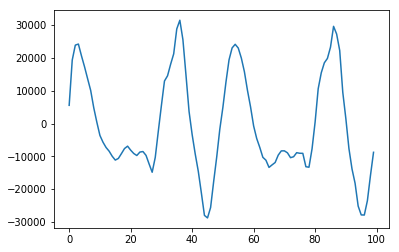

In [35]:
plt.plot(output[:100])

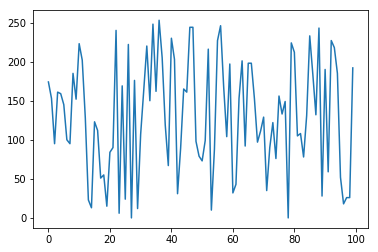

In [36]:
plt.plot(f[:100])

In [37]:
def save_wav(y, filename, sample_rate) :
    y = np.clip(y, -2**15, 2**15 - 1)
    wavfile.write(filename, sample_rate, y.astype(np.int16))

In [38]:
save_wav(output, f'model_outputs/{notebook_name}/3k_steps.wav', sample_rate)

In [39]:
model_path = f'model_checkpoints/{notebook_name}.pyt'

In [40]:
# torch.save(model.state_dict(), model_path)

In [41]:
# model.load_state_dict(torch.load(model_path))